In [1]:
!pwd
!date
!ls

/home/sphere/github/Sphere/Data2013/currents
Чт апр 26 16:00:37 MSK 2018
1currents.txt  5currents.txt	     Hamamatsu_currents_2013.ipynb
2currents.txt  Currents_2013.ipynb   High_ham.2012.dat
3currents.txt  currents_2013.txt     High_ham.2013.csv
4currents.txt  Hamamatsu_2013.ipynb  High_ham.dat


In [2]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mp
from tqdm import tqdm
import math as mt
import numpy as np

from matplotlib import dates
import datetime as dt

In [3]:
plt.rcParams['figure.figsize'] =(8,4)
plt.rcParams['lines.markersize'] = 3.5
plt.rcParams['lines.markeredgewidth'] = 1
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['grid.alpha'] = 0.7
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['font.size'] = 14

In [51]:
def plot_cur(param):
    fmt = dates.DateFormatter('%H:%M')
    plcol = ['m+-','bx--', 'gs:', 'rd-.', 'co-']

    #cur = 'cur' + str(pmt)
    cur = str(param)

    plt.rcParams['figure.figsize'] = (12,4)
    fig, ax = plt.subplots()
    for i in range(1, 6):
        data = ham[ham.run == i]
        x = [dt.datetime.strptime(i, "%H:%M:%S") for i in data.time]
        y = data[cur]
        label = 'run' + str(i) 
        ax.plot(x, y, plcol[i-1], label = label)

    ax.xaxis.set_major_formatter(fmt)
    ax.set_title(param)
    plt.legend(borderaxespad=0.1)
    plt.grid()

### Чтение данных

In [57]:
datum = []
for i in range(1, 6):
    filename = str(i) + 'currents.txt'
    data = pd.read_csv(filename, header = 0, index_col=0, sep='\t')
    data['run'] = i
    datum.append(data)
datum = pd.concat(datum)
params = ['time','cur1','run']
datum = datum[params]
datum.head(2)

,time,cur1,run
N,,,
10675,13:13:07,3.0,1
10676,13:13:07,3.0,1


In [58]:
data = pd.read_csv('High_ham.2013.csv', header = 0, index_col=0)
data.head(2)

,kod,T,HV1,HV10
N,,,,
10675,61,-23.0,-89.7,-944.2
10676,61,-23.0,-89.7,-944.2


In [59]:
ham = datum.join(data)
ham.head()

,time,cur1,run,kod,T,HV1,HV10
N,,,,,,,
10675,13:13:07,3.0,1,61,-23.0,-89.7,-944.2
10676,13:13:07,3.0,1,61,-23.0,-89.7,-944.2
10677,13:17:59,3.1,1,61,-23.0,-89.7,-944.2
10678,13:17:59,3.1,1,61,-23.0,-89.7,-944.2
10679,13:18:13,3.2,1,61,-23.0,-89.7,-944.2


### Поправки на токи

Во втором полёте напряжение на ФЭУ0 в 17:33 было изменено с кода 69 на код 92. Приведем все токи к напряжению 92, считая зависимость тока от напряжения линейной. 
Событие 11463 в 17:23 - код высокого 69, ток 2.5.
Событие 11464 в 17:33 - код высокого 92, ток 3.1
Считаем, что за 10 минут ток не изменился. Домножим все токи событий на соответствующие коэффициенты, приведя их к напряжению с кодом 92.

In [60]:
ham.kod.value_counts()

82    2390
65     595
64     308
69     172
92     164
91     162
61      10
Name: kod, dtype: int64

In [61]:
# приведение токов к коду высокого 92
x = [   61,    64,    65,   69,    82,   91,  92]
y = [1.324, 1.292, 1.282, 1.24, 1.105, 1.01, 1.0]

def func0(kod):
    return y[x.index(kod)]
    
ham['cur0'] = ham.apply(lambda x: x.cur1 * func0(x.kod), axis = 1)

### Графики

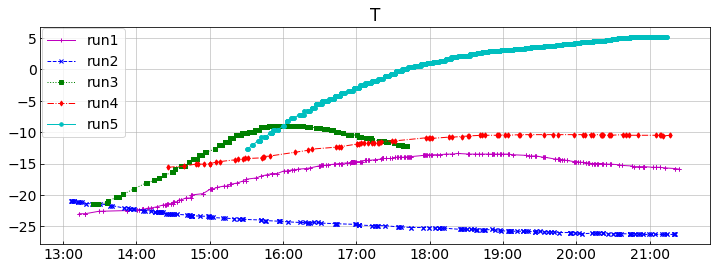

In [62]:
# Температура
plot_cur('T')

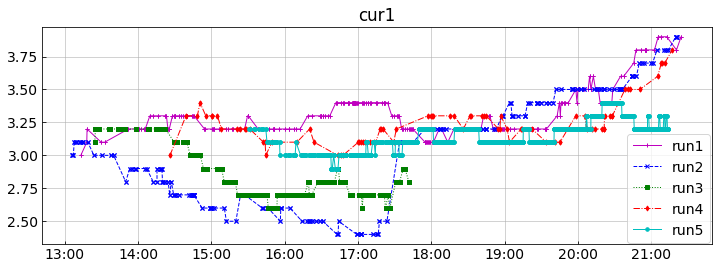

In [63]:
# Зарегистрированные токи
plot_cur('cur1')

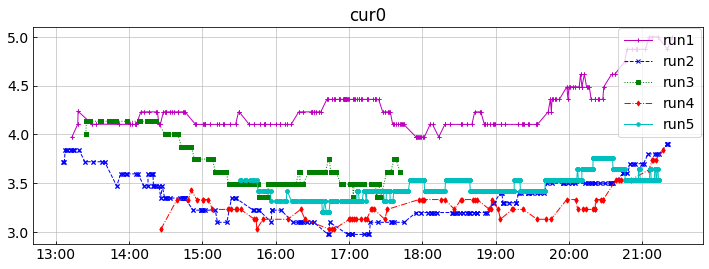

In [64]:
# Токи, приведенные к высокому напряжению с кодом 92
plot_cur('cur0')

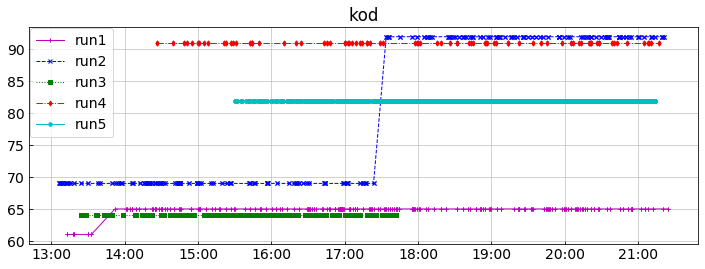

In [65]:
# Код высокого напряжения
plot_cur('kod')

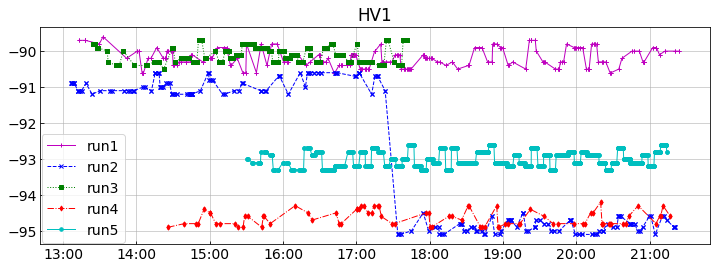

In [66]:
# Напряжение на первом диноде, измеренное
plot_cur('HV1')

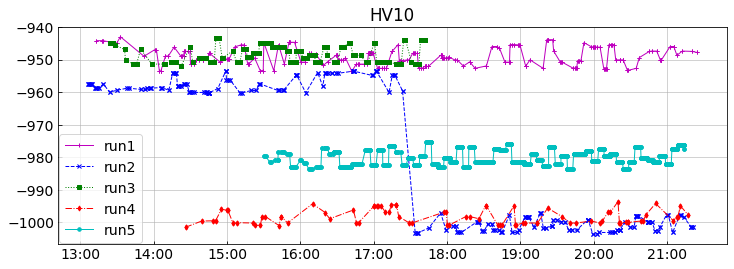

In [67]:
# Напряжение на десятом диноде, посчитанное из измеренного HV1
plot_cur('HV10')

### Коэффициенты для пересчета к напряжению c кодом 92

Point2D(0, 49/25)
[[69.0 1.24]
 [92.0 1.0]
 [0 49/25]]


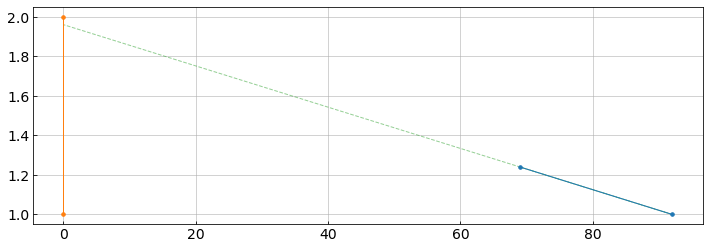

In [68]:
import matplotlib.pyplot as plt
from sympy import Line, Point, Segment
import numpy as np

x1, y1 = [69, 92], [1.24, 1]
x2, y2 = [0, 0], [2, 1]

# объекты точек
p1, p2, p3, p4 = (Point(x1[0], y1[0]), Point(x1[1], y1[1]),
                  Point(x2[0], y2[0]), Point(x2[1], y2[1]))

# объекты прямых для установления факта пересечения
# объекты отрезков для проверки наличия точки пересечения уже на отрезке
line1, seg1 = Line(p1, p2), Segment(p1, p2)
line2, seg2 = Line(p3, p4), Segment(p3, p4)

intersect = line1.intersection(line2)

l1, = plt.plot(x1, y1, marker='o', zorder=3)
l2, = plt.plot(x2, y2, marker='o', zorder=3)

if intersect:
    pi = intersect[0]
    print(pi)
    if not seg1.contains(pi):
        xydata = l1.get_xydata()
        xydata = np.vstack((xydata, [pi.x, pi.y]))
        print(xydata)
        plt.plot(xydata[:, 0], xydata[:, 1], '--', alpha=.5)
    if not seg2.contains(pi):
        xydata = l2.get_xydata()
        xydata = np.vstack((xydata, [pi.x, pi.y]))
        print(xydata)
        plt.plot(xydata[:, 0], xydata[:, 1], '--', alpha=.5)    
plt.grid()


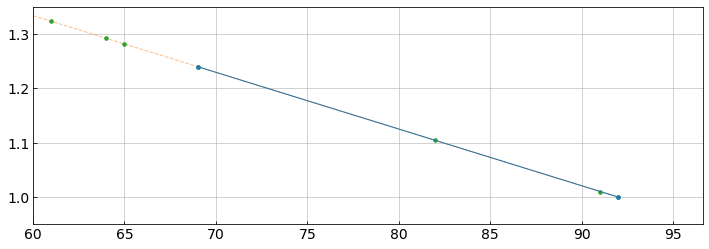

In [73]:
x = [   61,    64,    65,   69,    82,   91,  92]
y = [1.324, 1.292, 1.282, 1.24, 1.105, 1.01, 1.0]
l1, = plt.plot(x1, y1, marker='o', zorder=3)
plt.plot(xydata[:, 0], xydata[:, 1], '--', alpha=.5) 
plt.plot(x, y, 'o')
plt.xlim(60)
plt.ylim(0.95,1.35)
plt.grid()